### Training point contributions (based on Chris' notebook calculate_ppd)

From Rasmussen & Williams, the way that the mean of the PPD is calculated is through a linear combination of the values of the training function at each training point, where the coefficients for each training point are given by:

$$\bar{f_\star}=K(X_\star,X) C(X,X)^{-1}\mathbf{f}$$

Where $C(X,X) = K(X,X) + \sigma_n^2 \delta_K$ has a contribution from the noise variance.

In this notebook, we define these weights as $W(X_\star,X)\equiv K(X_\star,X) C(X,X)^{-1}$ and aim to plot them to give some visual representation of how a given emulator prediction is actually made from the training data. Whilst the above equation can be evaluated for a vector $f_\star$, essentially corresponding to making several emulator calls simulaneously at once, for simplicity in this case we evaluate it at just one point in parameter space. This means $K(X_\star,X)$ a row vector with each element being the covariance between the test point and each training point. Then the product of $K(X_\star,X) C(X,X)^{-1}=W(X_\star,X)$ is another row vector, where each entry represents the contribution to the linear combination of each training point, which is the quantity of interest in this notebook.

In particular I want to evaluate this equation myself to see if it gives the correct prediction, to ensure that the plots I have been making are correct and that this is in fact what the GP is doing. I will start off by looking at just the combined kernel.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
# our own modules
import gp_emulator
import p1d_arxiv
import test_simulation
import matplotlib
import copy

font = {'size'   : 14}

matplotlib.rc('font', **font)
plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=None
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0

In [3]:
# Set up emulator training set
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [4]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,
                                kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [5]:
## Set up test simulation object
test_sim=test_simulation.TestSimulation(sim_label="central",
            basedir=basedir,skewers_label=skewers_label,z_max=4,kmax_Mpc=kmax_Mpc,kp_Mpc=arxiv.kp_Mpc)
## and choose a particular test point
emu_call_dict=test_sim.get_emulator_calls(2.75)
print('test point (parameters in absolute values)',emu_call_dict)
emu_call=emu.return_unit_call(emu_call_dict)
print('test point (parameters in unit cube values)',emu_call)

test point (parameters in absolute values) {'mF': 0.7191184346490203, 'gamma': 1.5246254858011445, 'kF_Mpc': 10.258134266642543, 'sigT_Mpc': 0.12913148261050889, 'Delta2_p': 0.39720634331839777, 'n_p': -2.300054348768763, 'alpha_p': -0.2153610787031535, 'f_p': 0.9777158609861263}
test point (parameters in unit cube values) [0.7355107935616605, 0.6156988969712539, 0.5695818403891555, 0.30448169619870147, 0.3787774694713779, 0.49943907853007713]


In [6]:
## Set up test point in the right format for GPy
test_point=np.expand_dims(emu_call,axis=0)
## Set up training points used in the emulator (270 entries, 6 parameters each)
training_points=emu.X_param_grid
n_train,n_param=training_points.shape
## The first entry is the test point defined above
## The remining entries are the position vectors for each training point
## Have to do it this way as GPy doesn't allow individual calculations of the covariances apparently
test_and_training=np.concatenate((test_point,training_points),axis=0)

In [7]:
## Now calculate the kernel matrices 
## These matrices are actually: K_tot = K(X*,X*), K(X*,X)
##                                      K(X,X*) , K(X,X)
#K_tot=emu.gp.kern.linear.K(test_and_training)
K_tot=emu.gp.kern.rbf.K(test_and_training)
#K_tot=emu.gp.kern.K(test_and_training)

In [8]:
## so we define K(X*,X) and C(X,X) = K(X,X) + sigma_n below
K_star=K_tot[0,1:]
C_train=K_tot[1:,1:] + emu.gp.Gaussian_noise.variance*np.eye(n_train)

<Figure size 2100x2100 with 0 Axes>

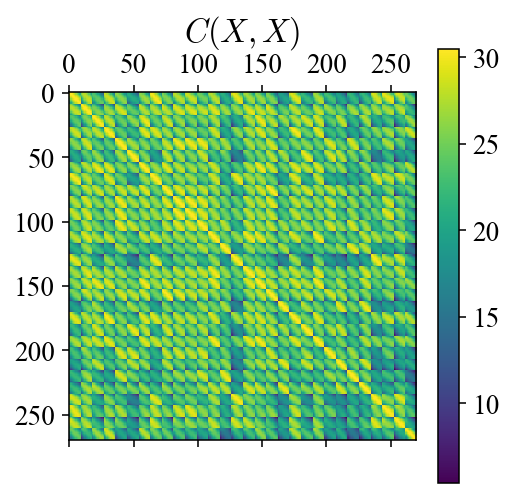

In [9]:
# plot covariance matrix (including noise, although negligible)
plt.figure(figsize=(15,15))
plt.matshow(C_train)
plt.title(r"$C(X,X)$")
plt.colorbar();

In [10]:
# inspect eigenvalues of covariance of training points
eigval,eigvec=np.linalg.eig(C_train)
print(np.min(eigval),' < eigen_value < ',np.max(eigval))

7.074925507979267e-06  < eigen_value <  6226.419945148145


In [11]:
# inverse covariance and compute weights
inv_C_train=np.linalg.inv(C_train) 
W_star=np.matmul(K_star,inv_C_train)

<Figure size 2100x2100 with 0 Axes>

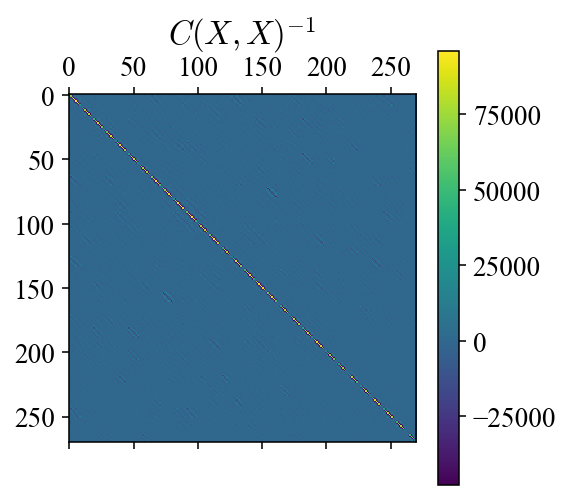

In [12]:
# plot inverse covariance for training points
plt.figure(figsize=(15,15))
plt.matshow(inv_C_train)
plt.title(r"$C(X,X)^{-1}$")
plt.colorbar();

In [13]:
# compute Euclidean distances from training points to test point
def euclidean_distance(p1,p2):
    return np.sqrt(np.sum((p1-p2)**2))
distances=[euclidean_distance(test_point,training_points[i]) for i in range(n_train)]
print(np.min(distances),' < distance < ',np.max(distances))

0.22610735344016553  < distance <  1.2607680489078392


Text(0, 0.5, 'Contribution to test prediction')

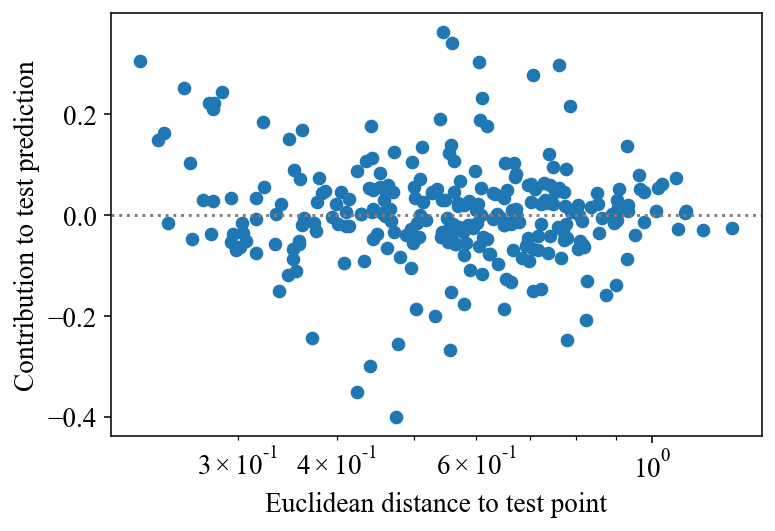

In [14]:
# plot contribution vs Euclidean distance
plt.semilogx(distances,W_star,'o')
plt.axhline(y=0.,ls=':',color='gray')
plt.xlabel('Euclidean distance to test point')
plt.ylabel('Contribution to test prediction')

In [15]:
## Select parameters along which to project
param1="mF"
param2="Delta2_p"

emu_data=arxiv.data
Nemu=len(emu_data)

emu_1=np.empty(Nemu)
emu_2=np.empty(Nemu)

ppd_weight=np.empty(Nemu)

for aa in range(Nemu):
    emu_1[aa]=emu_data[aa][param1]
    emu_2[aa]=emu_data[aa][param2]
    ppd_weight[aa]=W_star[aa]
    
## Point where the emu calls were made
call_1=emu_call_dict[param1]
call_2=emu_call_dict[param2]

In [16]:
## Select colourmap
cmap=cm.PiYG

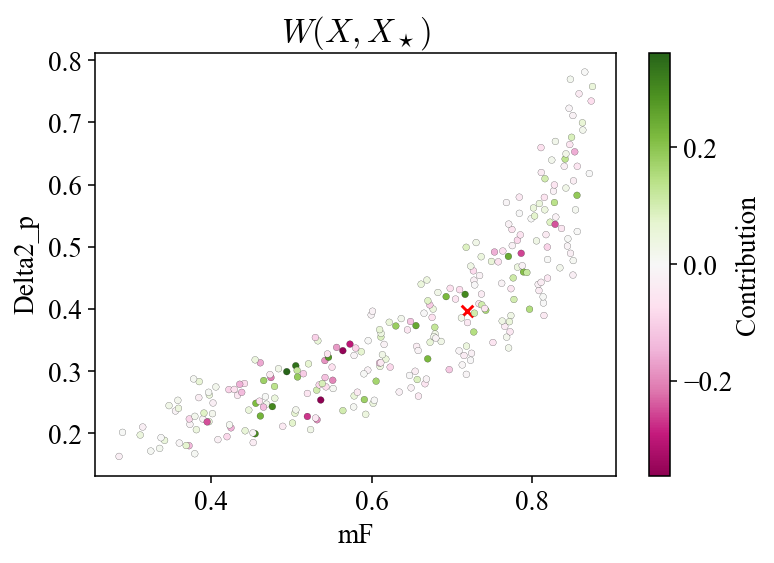

In [17]:
zmax=max(ppd_weight)
zmin=-1.*zmax

plt.title(r"$W(X,X_\star)$")
plt.scatter(call_1,call_2,c="red",marker="x",vmin=zmin, vmax=zmax)
plt.scatter(emu_1,emu_2,c=ppd_weight,s=12,vmin=zmin, vmax=zmax,cmap=cmap,edgecolor="black",linewidth=0.1)
cbar=plt.colorbar()
cbar.set_label("Contribution", labelpad=+1)
plt.xlabel(param1)
plt.ylabel(param2)
plt.show()

This looks bizarre, as the majority of the contributions to the prediction come from training points far away. I don't know that this is necessarily pathological though. There are several small tweaks being made to the prediction by training points in the vicinity of the test point. It's possible that as the test point moves around, these contributions are finely tweaked to model the changes in the function. 

# Test my prediction vs that of GPy

To test this, I will evaluate the equation at the top of this text myself using the weights shown in the plot, and see if what I get out agrees with the emulator prediction.

In [18]:
# Get y-value in training points
training_y=emu.Ypoints

In [19]:
# calculate my own prediction
my_pred=np.dot(W_star,training_y)
# ask GPy for the prediction
emu_pred,cov=emu.predict(emu_call_dict)

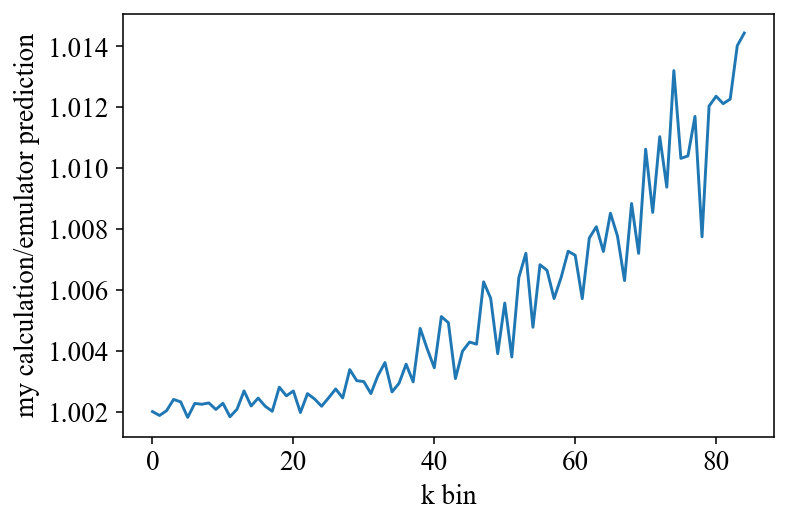

In [20]:
# plot ratio of predictions
plt.plot(my_pred/emu_pred)
plt.ylabel("my calculation/emulator prediction")
plt.xlabel("k bin");